In [31]:
import pandas as pd

data = pd.read_csv('./penguins.csv')

In [32]:
data.head(10)

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0
6,38.9,17.8,181.0,3625.0,0
7,39.2,19.6,195.0,4675.0,0
8,34.1,18.1,193.0,3475.0,0
9,42.0,20.2,190.0,4250.0,0


In [3]:
data.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

# Let's drop em

In [4]:
data = data.dropna()

In [5]:
data.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

In [6]:
data.shape

(342, 5)

# Normalize the data

In [7]:
data['FlipperLength'] = data['FlipperLength']/10
data['BodyMass'] = data['BodyMass']/100

In [8]:
# too low datasets; let's make it bigger
for i in range(1,3):
    data = data.append(data)

In [9]:
data.shape

(1368, 5)

# Let's build pyTorch Model

In [10]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
labels = 'Species'

x_train, x_test, y_train, y_test = train_test_split(data[features].values, data[labels].values, test_size=0.30, random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))

Training Set: 957, Test Set: 411 



In [11]:
# install and import pytorch libraries
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [12]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.7.1+cpu


# Prepare the data for PyTorch

In [13]:
# Train data
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x, train_y)
train_loader = td.DataLoader(train_ds, batch_size=20, shuffle=False, num_workers=1)

# test data
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x, test_y)
test_loader = td.DataLoader(test_ds, batch_size=20, shuffle=False, num_workers=1)

# Neural Network Setup

In [14]:
# number of neurons in each laeyss

NN = 10

class NModel(nn.Module):
    def __init__(self):
        super(NModel, self).__init__()
        self.fc1 = nn.Linear(len(features), NN)
        self.fc2 = nn.Linear(NN, NN)
        self.fc3 = nn.Linear(NN, 3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        
        return x
model = NModel()
print(model)

NModel(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


# Train and Test

In [15]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# Specify the loss criteria (CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 1.091498
Validation set: Average loss: 1.025534, Accuracy: 246/411 (60%)

Epoch: 2
Training set: Average loss: 1.000949
Validation set: Average loss: 0.982450, Accuracy: 314/411 (76%)

Epoch: 3
Training set: Average loss: 0.953905
Validation set: Average loss: 0.937909, Accuracy: 321/411 (78%)

Epoch: 4
Training set: Average loss: 0.906742
Validation set: Average loss: 0.893166, Accuracy: 322/411 (78%)

Epoch: 5
Training set: Average loss: 0.860262
Validation set: Average loss: 0.853027, Accuracy: 322/411 (78%)

Epoch: 6
Training set: Average loss: 0.818910
Validation set: Average loss: 0.816758, Accuracy: 323/411 (79%)

Epoch: 7
Training set: Average loss: 0.783247
Validation set: Average loss: 0.782575, Accuracy: 334/411 (81%)

Epoch: 8
Training set: Average loss: 0.750349
Validation set: Average loss: 0.748868, Accuracy: 353/411 (86%)

Epoch: 9
Training set: Average loss: 0.719538
Validation set: Average loss: 0.718091, Accuracy: 373/411 (91%)

E

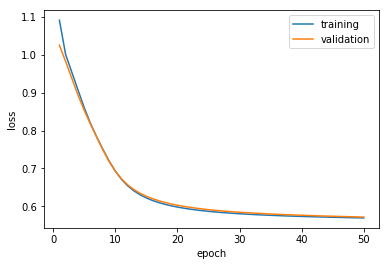

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# model weights and biases

In [17]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-0.00374341  0.2682218  -0.41152257 -0.3679695 ]
 [-0.20487966 -0.28398493  0.13597898  0.6053104 ]
 [-0.04437202  0.13230628 -0.15110654 -0.09828269]
 [-0.47767425 -0.33114105 -0.20611155  0.01852179]
 [ 0.17907079  0.28123733 -0.35748705 -0.23587279]
 [ 0.40088734  0.382148   -0.20181231  0.3537034 ]
 [-0.08059168  0.05290705  0.4527381  -0.46383518]
 [-0.35555413 -0.16605727 -0.23530953  0.38971528]
 [-0.32408983 -0.23016644 -0.34932023 -0.4682805 ]
 [-0.43653095  0.80248505  0.29239044  0.17577983]]
fc1.bias 
 [ 0.02629578 -0.26949045  0.08459234 -0.46684736 -0.3798124  -0.4262236
  0.31546897  0.25337356 -0.22174752  0.2345465 ]
fc2.weight 
 [[ 2.02246875e-01  3.14372510e-01  1.25505149e-01  4.27201092e-02
   2.12026387e-01 -1.86195642e-01  5.89271486e-02 -2.45173126e-01
  -2.19173074e-01 -1.63358063e-01]
 [ 1.43084526e-01  1.60798699e-01 -1.87318310e-01  9.55346525e-02
   1.92188621e-01  1.52368024e-01  1.20740533e-02  4.16618437e-02
   1.96180314e-01  9.25334394e-

# How good is the model?

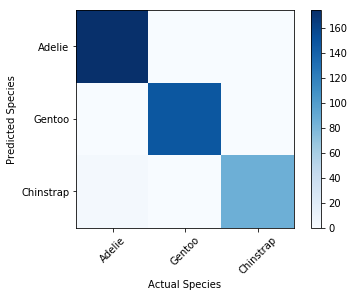

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']

cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Actual Species")
plt.ylabel("Predicted Species")
plt.show()

# Tensorflow Version

In [21]:
import pandas as pd

data = pd.read_csv('./penguins.csv').dropna()

data['FlipperLength'] = data['FlipperLength']/10
data['BodyMass'] = data['BodyMass']/100

for i in range(1,3):
    data = data.append(data)

In [22]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
labels = 'Species'

x_train, x_test, y_train, y_test = train_test_split(data[features].values, data[labels].values, test_size=0.30, random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))

Training Set: 957, Test Set: 411 



In [23]:
!pip install --upgrade tensorflow

  Using cached https://files.pythonhosted.org/packages/a1/6b/7f62017e3f0b32438dd90bdc1ff0b7b1448b6cb04a1ed84f37b6de95cd7b/h5py-2.10.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/60/7a/e881b5abb54db0e6e671ab088d079c57ce54e8a01a3ca443f561ccadb37e/typing_extensions-3.7.4.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
  Stored in directory: C:\Users\USER\AppData\Local\pip\Cache\wheels\b1\c2\ed\d62208260edbd3fa7156545c00ef966f45f2063d0a84f8208a
Successfully built wrapt
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: grpcio 1.24.3
    Uninstalling grpcio-1.24.3:
      Successfully uninstalled grpcio-1.24.3
  Found existing installation: absl-py 0.8.1
    Uninstalling absl-py-0.8.1:
      Successfully uninstalled absl-py-0.8.1
  Found exis

astroid 2.2.5 requires typed-ast>=1.3.0; implementation_name == "cpython", which is not installed.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\user\\anaconda3\\lib\\site-packages\\~-mpy\\.libs\\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [24]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras import optimizers

# Set random seed for reproducability
tensorflow.random.set_seed(0)

print("Libraries imported.")
print('Keras version:',keras.__version__)
print('TensorFlow version:',tensorflow.__version__)

Libraries imported.
Keras version: 2.2.4-tf
TensorFlow version: 2.0.0-alpha0


In [25]:
# Set data types for float features
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Set data types for categorical labels
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [26]:
model = Sequential()
model.add(Dense(10, input_dim=len(features), activation='relu'))
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(len(penguin_classes), input_dim=10, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
learning_rate = 0.001
opt = optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

num_epochs = 50
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=10, validation_data=(x_test, y_test))

Train on 957 samples, validate on 411 samples
Epoch 1/50
957/957 [==============================] - ETA: 22s - loss: 34.9876 - accuracy: 0.30 - ETA: 0s - loss: 30.2694 - accuracy: 0.1875 - 0s 483us/sample - loss: 24.2906 - accuracy: 0.1912 - val_loss: 11.6705 - val_accuracy: 0.2165
Epoch 2/50
957/957 [==============================] - ETA: 0s - loss: 13.1846 - accuracy: 0.100 - ETA: 0s - loss: 7.4084 - accuracy: 0.203 - 0s 114us/sample - loss: 5.3083 - accuracy: 0.2257 - val_loss: 1.6073 - val_accuracy: 0.3309
Epoch 3/50
957/957 [==============================] - ETA: 0s - loss: 1.7195 - accuracy: 0.30 - ETA: 0s - loss: 1.3424 - accuracy: 0.21 - 0s 118us/sample - loss: 1.2737 - accuracy: 0.2727 - val_loss: 1.1593 - val_accuracy: 0.3698
Epoch 4/50
957/957 [==============================] - ETA: 0s - loss: 1.3012 - accuracy: 0.30 - ETA: 0s - loss: 1.1230 - accuracy: 0.38 - 0s 115us/sample - loss: 1.1009 - accuracy: 0.4002 - val_loss: 1.0774 - val_accuracy: 0.4258
Epoch 5/50
957/957 [====

957/957 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 1.00 - ETA: 0s - loss: 0.2156 - accuracy: 0.95 - ETA: 0s - loss: 0.1976 - accuracy: 0.96 - 0s 144us/sample - loss: 0.1942 - accuracy: 0.9603 - val_loss: 0.2071 - val_accuracy: 0.9586
Epoch 37/50
957/957 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 1.00 - ETA: 0s - loss: 0.1780 - accuracy: 0.96 - 0s 102us/sample - loss: 0.1795 - accuracy: 0.9613 - val_loss: 0.1954 - val_accuracy: 0.9635
Epoch 38/50
957/957 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 1.00 - ETA: 0s - loss: 0.1765 - accuracy: 0.96 - 0s 110us/sample - loss: 0.1708 - accuracy: 0.9624 - val_loss: 0.1850 - val_accuracy: 0.9708
Epoch 39/50
957/957 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 1.00 - ETA: 0s - loss: 0.1550 - accuracy: 0.97 - 0s 113us/sample - loss: 0.1603 - accuracy: 0.9718 - val_loss: 0.1809 - val_accuracy: 0.9538
Epoch 40/50
957/957 [=========================

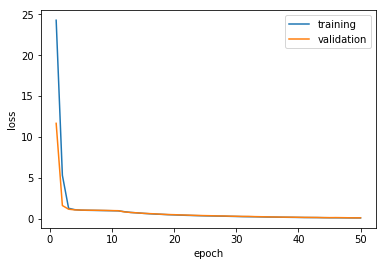

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [29]:
for layer in model.layers:
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    print('------------\nWeights:\n',weights,'\nBiases:\n', biases)

------------
Weights:
 [[-0.27236846 -0.3841947   0.03234848  0.08020484 -0.10909867  0.06330433
  -0.19313203  0.84640336  0.36701852 -0.4905011 ]
 [ 0.27471453  0.21265197  0.08079417 -0.17707926 -0.10406601  0.80510986
   0.3481228  -0.04539559 -0.62267196 -0.5447268 ]
 [-0.28836262 -0.634329    0.28234363  0.34767175  0.23550075 -0.00817027
   0.14570452 -0.7969777  -0.5233428   0.3296095 ]
 [-0.42851955 -0.24623463 -0.2871196  -0.5230521  -0.43773973  0.37682083
  -0.0763066   0.23378253  0.74960405 -0.4691702 ]] 
Biases:
 [ 0.          0.         -0.01398832  0.          0.          0.20292243
 -0.19176428 -0.2576086  -0.3294029   0.        ]
------------
Weights:
 [[ 0.0607031  -0.30530828  0.39975524  0.3037489   0.15896738  0.03326017
  -0.53190327  0.40915883 -0.03316814 -0.1240823 ]
 [ 0.42301047  0.14984506 -0.54566675  0.3919103  -0.4295466   0.50397205
  -0.31616646  0.17803025 -0.41518384 -0.38429344]
 [ 0.5336163   0.37752342 -0.46671256  0.17206895 -0.04215616  0.52979

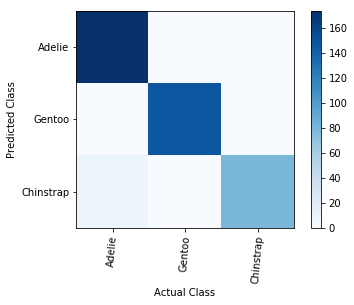

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=85)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()